In [1]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from model import RetinoblastomaClassifierNonBinaryCNN

In [2]:
import wandb

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import copy

In [4]:
transformer = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
dataset = datasets.ImageFolder(root="processed_dataset/training/", transform=transformer)
val_dataset = datasets.ImageFolder(root="processed_dataset/validation/", transform=transformer)

total_size = len(dataset)
train_size = int(0.9 * total_size)

test_size = total_size - train_size 

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)

In [6]:
dataset.class_to_idx

{'healthy': 0, 'retinoblastoma': 1}

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda')

In [9]:
def model_train(model, optimizer, criterion, dataloader):
    model.train()
    actual = []
    predicted = []

    
    for batch in dataloader:
        images, labels = batch
        labels = labels.to(device)
        images = images.to(device)
        
        preds = model(images) 
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted_classes = torch.max(preds, 1)
        
        for label in labels.tolist(): actual.append(int(label))
        for predicted_class in predicted_classes.tolist(): predicted.append(int(predicted_class))
    
    actual = np.array(actual) 
    predicted = np.array(predicted)
    
    return actual, predicted

In [10]:
def model_eval(model,dataloader):
    model.eval()
    actual = []
    predicted = []
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            
            labels = labels.to(device)
            images = images.to(device)
            
            preds = model(images)
            #loss = criterion(preds, labels)
            
            _, predicted_classes = torch.max(preds, 1)
            
            for label in labels.tolist(): actual.append(int(label))
            for predicted_class in predicted_classes.tolist(): predicted.append(int(predicted_class)) 
        
    actual = np.array(actual) 
    predicted = np.array(predicted)
    
    return actual, predicted

In [11]:
def create_confusion_matrix(actual,predicted, epoch):
    
    cm = confusion_matrix(actual,predicted)
    
    sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Healthy','Retinoblastoma'],
            yticklabels=['Healthy','Retinoblastoma'])
    plt.ylabel('Actual', fontsize=13)
    plt.title(f'Eval Confusion Matrix - Epoch #{epoch+1}', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()

    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [12]:
model = RetinoblastomaClassifierNonBinaryCNN().to(device) 

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0003

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50

In [13]:
wandb.init(
    # set the wandb entity where your project will be logged (generally your team name)
    entity="oleksii-oliinyk-lviv-polytechnic-national-university",

    # set the wandb project where this run will be logged
    project="eye-validation-cnn",

    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "CNN",
    "dataset": "custom-dataset",
    "epochs": num_epochs,
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: oleksii-oliinyk (oleksii-oliinyk-lviv-polytechnic-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:
model_name = "retinoblastoma_model_3"

In [15]:
f = open("../info/logs/retinoblastoma/" + model_name + ".txt", "w")

In [16]:
models_dict = []
best_eval_f1 = 0
patience = 8
patience_counter = 0

for i in range(num_epochs):
    
    
    epoch_message = f"Epoch #{i+1}"
    print(epoch_message)
    f.write(epoch_message + "\n")
    
    train_actual, train_predicted = model_train(model, optimizer, criterion, train_loader)
    eval_actual, eval_predicted = model_eval(model, test_loader)
    
    train_report = classification_report(train_actual, train_predicted, output_dict=True)
    train_report_message = "Training: \n" + str(classification_report(train_actual, train_predicted, zero_division=0))
    print(train_report_message)
    f.write(train_report_message + "\n")
    
    eval_report = classification_report(eval_actual, eval_predicted, output_dict=True)
    eval_report_message = "Evaluation: \n" + str(classification_report(eval_actual, eval_predicted, zero_division=0))
    print(eval_report_message)
    f.write(eval_report_message + "\n")
    
    create_confusion_matrix(eval_actual, eval_predicted, i)
    
    wandb.log({
        "Train/Precision": train_report["macro avg"]['precision'], 
        "Train/Recall": train_report["macro avg"]['recall'],
        "Train/F1-Score": train_report["macro avg"]['f1-score'],
        "Train/Accuracy": train_report["accuracy"],
        
        "Eval/Precision": eval_report["macro avg"]['precision'], 
        "Eval/Recall": eval_report["macro avg"]['recall'],
        "Eval/F1-Score": eval_report["macro avg"]['f1-score'],
        "Eval/Accuracy": eval_report["accuracy"]
    })

    
    models_dict.append(copy.deepcopy(model.state_dict()))
    if len(models_dict) > patience:
        models_dict.pop(0)
    
    eval_f1 = eval_report["macro avg"]['f1-score']
    
    if eval_f1 > best_eval_f1:
        best_eval_f1 = eval_f1
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping on epoch #{i+1}")
            print("Loading best model from saved history.")
            model.load_state_dict(models_dict[0])
            break

wandb.finish()


Epoch #1


RuntimeError: running_mean should contain 8 elements not 16

Validation: 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.90      0.90      0.90        21

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40



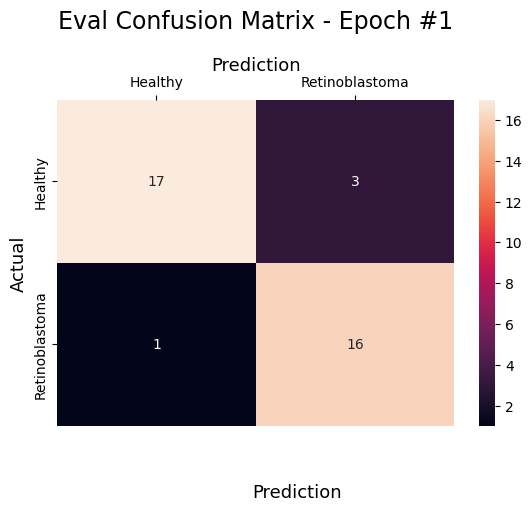

In [ ]:
validation_actual, validation_predicted = model_eval(model, val_loader)

validation_report = classification_report(validation_actual, validation_predicted, output_dict=True)
validation_report_message = "Validation: \n" + str(classification_report(eval_actual, eval_predicted, zero_division=0))
f.write(validation_report_message + "\n")
print(validation_report_message)
    
create_confusion_matrix(validation_actual, validation_predicted, 0)
f.close() 

In [ ]:
torch.save(model.state_dict(), "../info/models/retinoblastoma/" + model_name + ".pth")